# GUARDADO DE DATOS EN BRUTO DE CADA CICLÓN

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import pandas as pd
from geopy import distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geographiclib.geodesic import Geodesic
import time

In [2]:
def get_bearing(lat1, lat2, long1, long2):
    brng = Geodesic.WGS84.Inverse(lat1, long1, lat2, long2)['azi1']
    return brng

# Gráfico de celdas

In [18]:
from matplotlib.pylab import *

C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


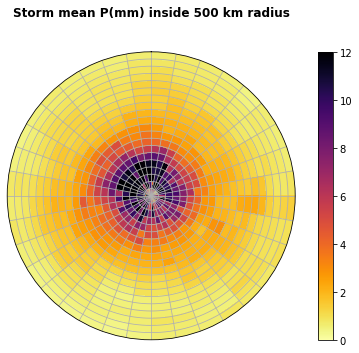

--- 8.662597417831421 seconds ---


In [34]:
start_time = time.time()

total_obs = []

#creación del mesh discretizado que quiero
th = np.array(range(0,370,10)) #discretización de ángulos
radius = np.array(range(0,525,25)) #discretización de radios
r, theta = np.meshgrid(radius,th) #mesh de r y theta

data = xr.open_dataset('WNP_cyclones/ciclon1.nc4')
data_id1 = np.array(data.id1)
data_id2 = np.array(data.id2)
dist = np.array(xr.open_dataarray('WNP_cyclones/dist_ciclon1.nc4'))
    
rad_ang = np.array(xr.open_dataarray('WNP_cyclones/angs_ciclon1.nc4'))
    
prec = np.array(xr.open_dataarray('WNP_cyclones/precip_ciclon1.nc4'))
#para seleccionar y cargar automaticamente el dato
for k in range(0,len(data.time)): 
    
    obs = np.zeros((r.shape))

    for i in range(obs.shape[0]):
        for j in range(obs.shape[1]):
            if j == 20 and i == 36 :
                index = np.intersect1d(np.where((np.ravel(dist[k,:data_id1[k],:data_id2[k]]) <= 500) & (np.ravel(dist[k,:data_id1[k],:data_id2[k]]) >= radius[j])),
                           np.where(((np.ravel(rad_ang[k,:data_id1[k],:data_id2[k]]) >= np.radians(th[i])))))
            elif j == 20:
                index = np.intersect1d(np.where((np.ravel(dist[k,:data_id1[k],:data_id2[k]]) <= 500) & (np.ravel(dist[k,:data_id1[k],:data_id2[k]]) >= radius[j])),
                           np.where((np.ravel(rad_ang[k,:data_id1[k],:data_id2[k]]) <= np.radians(th[i+1])) & (np.ravel(rad_ang[k,:data_id1[k],:data_id2[k]]) >= np.radians(th[i]))))
            elif i == 36:
                index = np.intersect1d(np.where((np.ravel(dist[k,:data_id1[k],:data_id2[k]]) <= radius[j+1]) & (np.ravel(dist[k,:data_id1[k],:data_id2[k]]) >= radius[j])),
                           np.where(((np.ravel(rad_ang[k,:data_id1[k],:data_id2[k]]) >= np.radians(th[i])))))
            else:
            
                index = np.intersect1d(np.where((np.ravel(dist[k,:data_id1[k],:data_id2[k]]) <= radius[j+1]) & (np.ravel(dist[k,:data_id1[k],:data_id2[k]]) >= radius[j])),
                           np.where((np.ravel(rad_ang[k,:data_id1[k],:data_id2[k]]) <= np.radians(th[i+1])) & (np.ravel(rad_ang[k,:data_id1[k],:data_id2[k]]) >= np.radians(th[i]))))
        
            precip = prec[k,:data_id1[k],:data_id2[k]]
            obs[i,j] = np.nanmean(np.ravel(precip)[index]) #cuando el index es un array vacío retorna nan, es decir no hay datos

    total_obs.append(obs)
    
#plot
obs = np.nanmean(np.array(total_obs), axis = 0)

fig = plt.figure(figsize=(16, 10))

ax0 = fig.add_axes([0,0,0.4,0.4], projection='polar')      

im = ax0.pcolormesh(np.radians(theta),r, obs, cmap='inferno_r', vmin = 0, vmax = 12)

ax0.set_theta_zero_location('N', offset=0)

ax0.set_theta_direction(-1)

ax0.set_title('Storm mean P(mm) inside 500 km radius\n', fontweight='bold')

ax0.set_thetagrids(range(0, 360, 10), labels = '')
ax0.set_rgrids(np.arange(0, 500, 25), labels='')

fig.colorbar(im)


ax0.grid('on')
    
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

# WNP
### EJEMPLO PARA TODOS LOS CICLONES

Una vez verificado que funciona, lo hacemos para todos los ciclones

In [3]:
xds_tracks = xr.open_dataset('Allstorms.ibtracs_wmo.v03r09.nc')

In [4]:
#ciclones de la cuenca WNP, hay 418
os.chdir('C:\\Users\\usuario\\Desktop\\trazasIB')
wnp = xr.open_dataset('basinWNP.nc4')
wnp

<xarray.Dataset>
Dimensions:   (storm: 418, time: 137)
Coordinates:
  * storm     (storm) int64 1301 1302 1303 1304 1305 ... 1715 1716 1717 1718
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 129 130 131 132 133 134 135 136
Data variables:
    latitud   (storm, time) float32 ...
    longitud  (storm, time) float32 ...
    presion   (storm, time) float32 ...
    fechas    (storm, time) datetime64[ns] ...

In [ ]:
start_time = time.time()

for t in range(0,418):
    storm = wnp.sel(storm = wnp.storm[t]) #seleccionamos la storm que corresponde en cada bucle
    
    storm_pres = storm.presion[~np.isnan(storm.presion)]
    storm_lat = storm.latitud[~np.isnan(storm.latitud)]
    storm_lon = storm.longitud[~np.isnan(storm.longitud)]
    storm_time = storm.fechas[~np.isnat(storm.fechas)]
    
    all_dist = []
    all_ang = []
    all_prec = []
    all_direction = []
    all_sst = []
    all_id1 = []
    all_id2 = []

    os.chdir('D:\oscar\dataset_modificado')
    
    for k in range(0,len(storm_time)-1): 
    
    #parseamos a string la fecha correspondiente para leer el fichero nc4 correspondiente al instante de tiempo
        

        ts = pd.to_datetime(str(storm_time.values[k]))
    
    #necesario porque al ser una base de datos 3 horarias se han "colado" observaciones externas en ese rango
        hora = ts.strftime('%H')
        if hora != '00' and hora != '03' and hora != '06' and hora != '09' and hora != '12' and hora != '15' and hora != '18' and hora != '21':
            continue
            
    
        
        day = ts.strftime('%Y%m%d-%H.nc4')
        
    
        precip = xr.open_dataset(day)
        precip_lat = np.array(precip.nlat[~np.isnan(precip.nlat)])
        precip_lon = np.array(precip.nlon[~np.isnan(precip.nlon)])
    
        #seleccionamos el centro y su sucesivo
        x = np.array(storm_lon[k])
        y = np.array(storm_lat[k])
        xnext = np.array(storm_lon[k+1])
        ynext = np.array(storm_lat[k+1])
        
        #seleccionamos sst del ciclón en ese instante
        sst = xr.open_dataset('SST\sst.day.mean.'+str(ts.strftime('%Y'))+'.nc')
        idx_time = np.where(pd.to_datetime(sst.time.values) == ts.strftime('%Y-%m-%d'))
        idx_lat = np.where(np.round(sst.lat.values, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
        #si idx_lat es vacío, redondeamos al decimal por abajo o por arriba
        idx_lat2 = np.where(np.round(np.round(sst.lat.values, decimals = 1)-0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1)) 
        idx_lat3 = np.where(np.round(np.round(sst.lat.values, decimals = 1)+0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
    
        if len(idx_lat[0]) == 0:
            idx_lat = idx_lat2
            if len(idx_lat2[0]) == 0:
                idx_lat = idx_lat3
    
        #como la longitud en sst va de 0-360 y en storm_lon de -180-180, hacemos una pequeña conversión para buscar el índice
        storm_lon_converted = storm_lon[k].values
        if storm_lon_converted < 0:
            storm_lon_converted = storm_lon_converted + 360
            
        idx_lon = np.where(np.round(sst.lon.values, decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon2 = np.where(np.round(np.round(sst.lon.values, decimals = 1)-0.1,decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon3 = np.where(np.round(np.round(sst.lon.values, decimals = 1)+0.1, decimals = 1)== np.round(storm_lon_converted,decimals=1))
    
        if len(idx_lon[0]) == 0:
            idx_lon = idx_lon2
            if len(idx_lon2[0]) == 0:
                idx_lon = idx_lon3
    
        #ahora que tenemos los 3 indices tiempo,longitud y latitud seleccionamos el valor de sst correspondiente
        
        sst_value = sst.sst[idx_time[0],idx_lat[0],idx_lon[0]].values
    #restringiremos los datos para optimizar el tiempo de computo a una resolucion 5x5
    
        precip_lon = precip_lon[np.where((precip_lon <= x + 5) & (precip_lon >= x - 5))]
        precip_lat = precip_lat[np.where((precip_lat <= y + 5) & (precip_lat >= y - 5))]
    
   

        direction = get_bearing(y,ynext,x,xnext)
    
        lons, lats = np.meshgrid(precip_lon,precip_lat)

        dist = np.empty((40,40))
        ang = np.empty((40,40))
    
        dist[:] = np.nan
        ang[:] = np.nan
        #cálculo de mallas de ángulos y radios
        
        for j in range(lons.shape[1]):
            for i in range(lats.shape[0]):
                coords = (lats[i,0], lons[0,j])
                dist[j,i] = distance.geodesic(coords, (y,x)).km 
                ang[j,i] = np.rad2deg(np.arctan2((lats[i,0]-y), (lons[0,j]-x)))
                
        if precip.precipitation.nlat.max() < y:
            continue
            
        x_min = np.min(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))
        x_max = np.max(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))

        y_min = np.min(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
        y_max = np.max(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
    
        precs = np.empty((40,40))
        precs[:] = np.nan
        prec = precip['precipitation'][0,x_min:x_max+1,y_min:y_max+1].values

        for i in range(prec.shape[0]):
            for j in range(prec.shape[1]):
                if prec[i,j] > 500:
                    precs[i,j] = np.nan
                else:
                    
                    precs[i,j] = prec[i,j]
    
    
        rad_ang = np.radians(ang)
        change = np.radians(np.full((40,40),  -direction))
        rad_ang = rad_ang + change
    
        rad_ang[rad_ang < 0] = np.radians(360+ np.degrees(rad_ang[rad_ang < 0]))
        
        rad_ang = np.array(rad_ang)
        dist = np.array(dist)
        prec = np.array(prec)
    
        
        all_direction.append(direction)
        all_prec.append(precs)
        all_ang.append(rad_ang)
        all_dist.append(dist)
        all_sst.append(sst_value[0][0][0])
        all_id1.append(lons.shape[1])
        all_id2.append(lats.shape[0])
        
    os.chdir('C:\\Users\\usuario\\Desktop\\trazasIB')
    #guardo archivos
    multidata=xr.Dataset({'minPressure': ('time',storm_pres[:len(storm_time)-1]),
            'latitude': ('time',storm_lat[:len(storm_time)-1]),
            'longitude': ('time',storm_lon[:len(storm_time)-1]),
            'azimuth': all_direction,
            'sst': all_sst,
            'id1': all_id1,
            'id2': all_id2
            },
          {'time': storm_time[:len(storm_time)-1]})
    
    multidata.to_netcdf('WNP_cyclones/ciclon'+str(t)+'.nc4')
    
    dist = xr.DataArray(all_dist)
    dist.to_netcdf('WNP_cyclones/dist_ciclon'+str(t)+'.nc4')
    
    angs = xr.DataArray(all_ang)
    angs.to_netcdf('WNP_cyclones/ang_ciclon'+str(t)+'.nc4')
    
    precs = xr.DataArray(all_prec)
    precs.to_netcdf('WNP_cyclones/precip_ciclon'+str(t)+'.nc4')

    print('cyclone'+str(t)+'done!') 

C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

In [8]:
os.chdir('C:\\Users\\usuario\\Desktop\\trazasIB')

In [32]:
import xarray as xr
xr.open_dataset('WNP_cyclones/ciclon417.nc4').azimuth

<xarray.DataArray 'azimuth' (azimuth: 21)>
array([ -73.938537,  -78.561109,  -77.768887,  -69.817767,  -67.129955,
        -71.309815,  -77.6271  ,  -72.991979,  -65.635615,  -84.085386,
        -85.023976,  -89.880955,  -79.387642,  -83.439393,  -82.647488,
        -71.135236,  -58.421961,    0.      ,  180.      ,  180.      ,
       -161.86337 ])
Coordinates:
  * azimuth  (azimuth) float64 -73.94 -78.56 -77.77 ... 180.0 180.0 -161.9
    storm    int64 ...

# SP

In [10]:
sp = xr.open_dataset('basinSP.nc4')
sp

<xarray.Dataset>
Dimensions:   (storm: 178, time: 137)
Coordinates:
  * storm     (storm) int64 599 601 602 603 604 605 ... 772 773 774 775 776 777
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 129 130 131 132 133 134 135 136
Data variables:
    latitud   (storm, time) float32 ...
    longitud  (storm, time) float32 ...
    presion   (storm, time) float32 ...
    fechas    (storm, time) datetime64[ns] ...

In [11]:
start_time = time.time()

for t in range(0,178):
    storm = sp.sel(storm = sp.storm[t]) #seleccionamos la storm que corresponde en cada bucle
    
    storm_pres = storm.presion[~np.isnan(storm.presion)]
    storm_lat = storm.latitud[~np.isnan(storm.latitud)]
    storm_lon = storm.longitud[~np.isnan(storm.longitud)]
    storm_time = storm.fechas[~np.isnat(storm.fechas)]
    
    all_dist = []
    all_ang = []
    all_prec = []
    all_direction = []
    all_sst = []
    all_id1 = []
    all_id2 = []

    os.chdir('D:\oscar\dataset_modificado')
    
    for k in range(0,len(storm_time)-1): 
    
    #parseamos a string la fecha correspondiente para leer el fichero nc4 correspondiente al instante de tiempo
        

        ts = pd.to_datetime(str(storm_time.values[k]))
    
    #necesario porque al ser una base de datos 3 horarias se han "colado" observaciones externas en ese rango
        hora = ts.strftime('%H')
        if hora != '00' and hora != '03' and hora != '06' and hora != '09' and hora != '12' and hora != '15' and hora != '18' and hora != '21':
            continue
            
    
        
        day = ts.strftime('%Y%m%d-%H.nc4')
        
    
        precip = xr.open_dataset(day)
        precip_lat = np.array(precip.nlat[~np.isnan(precip.nlat)])
        precip_lon = np.array(precip.nlon[~np.isnan(precip.nlon)])
    
        #seleccionamos el centro y su sucesivo
        x = np.array(storm_lon[k])
        y = np.array(storm_lat[k])
        xnext = np.array(storm_lon[k+1])
        ynext = np.array(storm_lat[k+1])
        
        #seleccionamos sst del ciclón en ese instante
        sst = xr.open_dataset('SST\sst.day.mean.'+str(ts.strftime('%Y'))+'.nc')
        idx_time = np.where(pd.to_datetime(sst.time.values) == ts.strftime('%Y-%m-%d'))
        idx_lat = np.where(np.round(sst.lat.values, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
        #si idx_lat es vacío, redondeamos al decimal por abajo o por arriba
        idx_lat2 = np.where(np.round(np.round(sst.lat.values, decimals = 1)-0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1)) 
        idx_lat3 = np.where(np.round(np.round(sst.lat.values, decimals = 1)+0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
    
        if len(idx_lat[0]) == 0:
            idx_lat = idx_lat2
            if len(idx_lat2[0]) == 0:
                idx_lat = idx_lat3
    
        #como la longitud en sst va de 0-360 y en storm_lon de -180-180, hacemos una pequeña conversión para buscar el índice
        storm_lon_converted = storm_lon[k].values
        if storm_lon_converted < 0:
            storm_lon_converted = storm_lon_converted + 360
            
        idx_lon = np.where(np.round(sst.lon.values, decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon2 = np.where(np.round(np.round(sst.lon.values, decimals = 1)-0.1,decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon3 = np.where(np.round(np.round(sst.lon.values, decimals = 1)+0.1, decimals = 1)== np.round(storm_lon_converted,decimals=1))
    
        if len(idx_lon[0]) == 0:
            idx_lon = idx_lon2
            if len(idx_lon2[0]) == 0:
                idx_lon = idx_lon3
    
        #ahora que tenemos los 3 indices tiempo,longitud y latitud seleccionamos el valor de sst correspondiente
        
        sst_value = sst.sst[idx_time[0],idx_lat[0],idx_lon[0]].values
    #restringiremos los datos para optimizar el tiempo de computo a una resolucion 5x5
    
        precip_lon = precip_lon[np.where((precip_lon <= x + 5) & (precip_lon >= x - 5))]
        precip_lat = precip_lat[np.where((precip_lat <= y + 5) & (precip_lat >= y - 5))]
    
   

        direction = get_bearing(y,ynext,x,xnext)
    
        lons, lats = np.meshgrid(precip_lon,precip_lat)

        dist = np.empty((40,40))
        ang = np.empty((40,40))
    
        dist[:] = np.nan
        ang[:] = np.nan
        #cálculo de mallas de ángulos y radios
        
        for j in range(lons.shape[1]):
            for i in range(lats.shape[0]):
                coords = (lats[i,0], lons[0,j])
                dist[j,i] = distance.geodesic(coords, (y,x)).km 
                ang[j,i] = np.rad2deg(np.arctan2((lats[i,0]-y), (lons[0,j]-x)))
                
        if precip.precipitation.nlat.min() > y:
            continue
            
        x_min = np.min(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))
        x_max = np.max(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))

        y_min = np.min(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
        y_max = np.max(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
    
        precs = np.empty((40,40))
        precs[:] = np.nan
        prec = precip['precipitation'][0,x_min:x_max+1,y_min:y_max+1].values

        for i in range(prec.shape[0]):
            for j in range(prec.shape[1]):
                if prec[i,j] > 500:
                    precs[i,j] = np.nan
                else:
                    
                    precs[i,j] = prec[i,j]
    
    
        rad_ang = np.radians(ang)
        change = np.radians(np.full((40,40),  -direction))
        rad_ang = rad_ang + change
    
        rad_ang[rad_ang < 0] = np.radians(360+ np.degrees(rad_ang[rad_ang < 0]))
        
        rad_ang = np.array(rad_ang)
        dist = np.array(dist)
        prec = np.array(prec)
    
        
        all_direction.append(direction)
        all_prec.append(precs)
        all_ang.append(rad_ang)
        all_dist.append(dist)
        all_sst.append(sst_value[0][0][0])
        all_id1.append(lons.shape[1])
        all_id2.append(lats.shape[0])
        
    os.chdir('C:\\Users\\usuario\\Desktop\\trazasIB')
    #guardo archivos
    multidata=xr.Dataset({'minPressure': ('time',storm_pres[:len(storm_time)-1]),
            'latitude': ('time',storm_lat[:len(storm_time)-1]),
            'longitude': ('time',storm_lon[:len(storm_time)-1]),
            'azimuth': all_direction,
            'sst': all_sst,
            'id1': all_id1,
            'id2': all_id2
            },
          {'time': storm_time[:len(storm_time)-1]})
    
    multidata.to_netcdf('SP_cyclones/ciclonsp'+str(t)+'.nc4')
    
    dist = xr.DataArray(all_dist)
    dist.to_netcdf('SP_cyclones/dist_ciclonsp'+str(t)+'.nc4')
    
    angs = xr.DataArray(all_ang)
    angs.to_netcdf('SP_cyclones/ang_ciclonsp'+str(t)+'.nc4')
    
    precs = xr.DataArray(all_prec)
    precs.to_netcdf('SP_cyclones/precip_ciclonsp'+str(t)+'.nc4')

    print('cyclone'+str(t)+'done!')   

C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone0done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone1done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone2done!
cyclone3done!
cyclone4done!
cyclone5done!
cyclone6done!
cyclone7done!
cyclone8done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone9done!
cyclone10done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone11done!
cyclone12done!
cyclone13done!
cyclone14done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone15done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone16done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone17done!
cyclone18done!
cyclone19done!
cyclone20done!
cyclone21done!
cyclone22done!
cyclone23done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone24done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone25done!
cyclone26done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone27done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone28done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone29done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone30done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone31done!
cyclone32done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone33done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone34done!
cyclone35done!
cyclone36done!
cyclone37done!
cyclone38done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone39done!
cyclone40done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone41done!
cyclone42done!
cyclone43done!
cyclone44done!
cyclone45done!
cyclone46done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone47done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone48done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone49done!
cyclone50done!
cyclone51done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone52done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone53done!
cyclone54done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone55done!
cyclone56done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone57done!
cyclone58done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone59done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone60done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone61done!
cyclone62done!
cyclone63done!
cyclone64done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone65done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone66done!
cyclone67done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone68done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone69done!
cyclone70done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone71done!
cyclone72done!
cyclone73done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone74done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone75done!
cyclone76done!
cyclone77done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone78done!
cyclone79done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone80done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone81done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone82done!
cyclone83done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone84done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone85done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone86done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone87done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone88done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone89done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone90done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning:

cyclone91done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone92done!
cyclone93done!
cyclone94done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone95done!
cyclone96done!
cyclone97done!
cyclone98done!
cyclone99done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone100done!
cyclone101done!
cyclone102done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone103done!
cyclone104done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone105done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone106done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone107done!
cyclone108done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone109done!
cyclone110done!
cyclone111done!
cyclone112done!
cyclone113done!
cyclone114done!
cyclone115done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone116done!
cyclone117done!
cyclone118done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone119done!
cyclone120done!
cyclone121done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone122done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone123done!
cyclone124done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone125done!
cyclone126done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone127done!
cyclone128done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone129done!
cyclone130done!
cyclone131done!
cyclone132done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone133done!
cyclone134done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone135done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone136done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone137done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone138done!
cyclone139done!
cyclone140done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone141done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone142done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone143done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone144done!
cyclone145done!
cyclone146done!
cyclone147done!
cyclone148done!
cyclone149done!
cyclone150done!
cyclone151done!
cyclone152done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone153done!
cyclone154done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone155done!
cyclone156done!
cyclone157done!
cyclone158done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone159done!
cyclone160done!
cyclone161done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone162done!
cyclone163done!
cyclone164done!
cyclone165done!
cyclone166done!
cyclone167done!
cyclone168done!
cyclone169done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone170done!
cyclone171done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone172done!
cyclone173done!
cyclone174done!
cyclone175done!
cyclone176done!
cyclone177done!


In [27]:
xr.open_dataset('SP_cyclones/ciclonsp177.nc4')

<xarray.Dataset>
Dimensions:      (azimuth: 9, id1: 9, id2: 9, sst: 9, time: 9)
Coordinates:
  * azimuth      (azimuth) float64 162.1 -99.85 71.04 ... 112.6 114.8 101.1
  * sst          (sst) float32 31.63 31.609999 31.89 ... 31.49 31.439999 29.71
  * id1          (id1) int32 40 40 40 40 40 40 40 40 40
  * id2          (id2) int32 40 40 40 40 40 40 40 40 40
    storm        int64 ...
  * time         (time) datetime64[ns] 2016-03-14T00:00:00.000043072 ... 2016-03-16T00:00:00.000043072
Data variables:
    minPressure  (time) float32 ...
    latitude     (time) float32 ...
    longitude    (time) float32 ...

### Modificando el ángulo en SP

In [3]:
sp = xr.open_dataset('basinSP.nc4')
sp

<xarray.Dataset>
Dimensions:   (storm: 178, time: 137)
Coordinates:
  * storm     (storm) int64 599 601 602 603 604 605 ... 772 773 774 775 776 777
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 129 130 131 132 133 134 135 136
Data variables:
    latitud   (storm, time) float32 ...
    longitud  (storm, time) float32 ...
    presion   (storm, time) float32 ...
    fechas    (storm, time) datetime64[ns] ...

In [5]:
start_time = time.time()

for t in range(0,178):
    storm = sp.sel(storm = sp.storm[t]) #seleccionamos la storm que corresponde en cada bucle
    
    storm_pres = storm.presion[~np.isnan(storm.presion)]
    storm_lat = storm.latitud[~np.isnan(storm.latitud)]
    storm_lon = storm.longitud[~np.isnan(storm.longitud)]
    storm_time = storm.fechas[~np.isnat(storm.fechas)]
    
    all_dist = []
    all_ang = []
    all_prec = []
    all_direction = []
    all_sst = []
    all_id1 = []
    all_id2 = []

    os.chdir('D:\oscar\dataset_modificado')
    
    for k in range(0,len(storm_time)-1): 
    
    #parseamos a string la fecha correspondiente para leer el fichero nc4 correspondiente al instante de tiempo
        

        ts = pd.to_datetime(str(storm_time.values[k]))
    
    #necesario porque al ser una base de datos 3 horarias se han "colado" observaciones externas en ese rango
        hora = ts.strftime('%H')
        if hora != '00' and hora != '03' and hora != '06' and hora != '09' and hora != '12' and hora != '15' and hora != '18' and hora != '21':
            continue
            
    
        
        day = ts.strftime('%Y%m%d-%H.nc4')
        
    
        precip = xr.open_dataset(day)
        precip_lat = np.array(precip.nlat[~np.isnan(precip.nlat)])
        precip_lon = np.array(precip.nlon[~np.isnan(precip.nlon)])
    
        #seleccionamos el centro y su sucesivo
        x = np.array(storm_lon[k])
        y = np.array(storm_lat[k])
        xnext = np.array(storm_lon[k+1])
        ynext = np.array(storm_lat[k+1])
        
        #seleccionamos sst del ciclón en ese instante
        sst = xr.open_dataset('SST\sst.day.mean.'+str(ts.strftime('%Y'))+'.nc')
        idx_time = np.where(pd.to_datetime(sst.time.values) == ts.strftime('%Y-%m-%d'))
        idx_lat = np.where(np.round(sst.lat.values, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
        #si idx_lat es vacío, redondeamos al decimal por abajo o por arriba
        idx_lat2 = np.where(np.round(np.round(sst.lat.values, decimals = 1)-0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1)) 
        idx_lat3 = np.where(np.round(np.round(sst.lat.values, decimals = 1)+0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
    
        if len(idx_lat[0]) == 0:
            idx_lat = idx_lat2
            if len(idx_lat2[0]) == 0:
                idx_lat = idx_lat3
    
        #como la longitud en sst va de 0-360 y en storm_lon de -180-180, hacemos una pequeña conversión para buscar el índice
        storm_lon_converted = storm_lon[k].values
        if storm_lon_converted < 0:
            storm_lon_converted = storm_lon_converted + 360
            
        idx_lon = np.where(np.round(sst.lon.values, decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon2 = np.where(np.round(np.round(sst.lon.values, decimals = 1)-0.1,decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon3 = np.where(np.round(np.round(sst.lon.values, decimals = 1)+0.1, decimals = 1)== np.round(storm_lon_converted,decimals=1))
    
        if len(idx_lon[0]) == 0:
            idx_lon = idx_lon2
            if len(idx_lon2[0]) == 0:
                idx_lon = idx_lon3
    
        #ahora que tenemos los 3 indices tiempo,longitud y latitud seleccionamos el valor de sst correspondiente
        
        sst_value = sst.sst[idx_time[0],idx_lat[0],idx_lon[0]].values
    #restringiremos los datos para optimizar el tiempo de computo a una resolucion 5x5
    
        precip_lon = precip_lon[np.where((precip_lon <= x + 5) & (precip_lon >= x - 5))]
        precip_lat = precip_lat[np.where((precip_lat <= y + 5) & (precip_lat >= y - 5))]
    
   

        direction = get_bearing(y,ynext,x,xnext)
    
        lons, lats = np.meshgrid(precip_lon,precip_lat)

        dist = np.empty((40,40))
        ang = np.empty((40,40))
    
        dist[:] = np.nan
        ang[:] = np.nan
        #cálculo de mallas de ángulos y radios
        
        for j in range(lons.shape[1]):
            for i in range(lats.shape[0]):
                coords = (lats[i,0], lons[0,j])
                dist[j,i] = distance.geodesic(coords, (y,x)).km 
                ang[j,i] = np.rad2deg(np.arctan2((lats[i,0]-y), (lons[0,j]-x)))
                
        if precip.precipitation.nlat.min() > y:
            continue
            
        x_min = np.min(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))
        x_max = np.max(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))

        y_min = np.min(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
        y_max = np.max(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
    
        precs = np.empty((40,40))
        precs[:] = np.nan
        prec = precip['precipitation'][0,x_min:x_max+1,y_min:y_max+1].values

        for i in range(prec.shape[0]):
            for j in range(prec.shape[1]):
                if prec[i,j] > 500:
                    precs[i,j] = np.nan
                else:
                    
                    precs[i,j] = prec[i,j]
    
        ang = 360 - ang
        rad_ang = np.radians(ang)
        change = np.radians(np.full((40,40),  -direction))
        rad_ang = rad_ang + change
    
        rad_ang[rad_ang < 0] = np.radians(360+ np.degrees(rad_ang[rad_ang < 0]))
        
        rad_ang = np.array(rad_ang)
        dist = np.array(dist)
        prec = np.array(prec)
    
        
        all_direction.append(direction)
        all_prec.append(precs)
        all_ang.append(rad_ang)
        all_dist.append(dist)
        all_sst.append(sst_value[0][0][0])
        all_id1.append(lons.shape[1])
        all_id2.append(lats.shape[0])
        
    os.chdir('C:\\Users\\usuario\\Desktop\\trazasIB')
    #guardo archivos
    multidata=xr.Dataset({'minPressure': ('time',storm_pres[:len(storm_time)-1]),
            'latitude': ('time',storm_lat[:len(storm_time)-1]),
            'longitude': ('time',storm_lon[:len(storm_time)-1]),
            'azimuth': all_direction,
            'sst': all_sst,
            'id1': all_id1,
            'id2': all_id2
            },
          {'time': storm_time[:len(storm_time)-1]})
    
    multidata.to_netcdf('SP_cyclones_mod/ciclonsp_mod'+str(t)+'.nc4')
    
    dist = xr.DataArray(all_dist)
    dist.to_netcdf('SP_cyclones_mod/dist_ciclonsp_mod'+str(t)+'.nc4')
    
    angs = xr.DataArray(all_ang)
    angs.to_netcdf('SP_cyclones_mod/ang_ciclonsp_mod'+str(t)+'.nc4')
    
    precs = xr.DataArray(all_prec)
    precs.to_netcdf('SP_cyclones_mod/precip_ciclonsp_mod'+str(t)+'.nc4')

    print('cyclone'+str(t)+'done!')   

C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone0done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone1done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone2done!
cyclone3done!
cyclone4done!
cyclone5done!
cyclone6done!
cyclone7done!
cyclone8done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone9done!
cyclone10done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone11done!
cyclone12done!
cyclone13done!
cyclone14done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone15done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone16done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone17done!
cyclone18done!
cyclone19done!
cyclone20done!
cyclone21done!
cyclone22done!
cyclone23done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone24done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone25done!
cyclone26done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone27done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone28done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone29done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone30done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone31done!
cyclone32done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone33done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone34done!
cyclone35done!
cyclone36done!
cyclone37done!
cyclone38done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone39done!
cyclone40done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone41done!
cyclone42done!
cyclone43done!
cyclone44done!
cyclone45done!
cyclone46done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone47done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone48done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone49done!
cyclone50done!
cyclone51done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone52done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone53done!
cyclone54done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone55done!
cyclone56done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone57done!
cyclone58done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone59done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone60done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone61done!
cyclone62done!
cyclone63done!
cyclone64done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone65done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone66done!
cyclone67done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone68done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone69done!
cyclone70done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone71done!
cyclone72done!
cyclone73done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone74done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone75done!
cyclone76done!
cyclone77done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone78done!
cyclone79done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone80done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone81done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone82done!
cyclone83done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone84done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone85done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone86done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone87done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone88done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone89done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone90done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning:

cyclone91done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone92done!
cyclone93done!
cyclone94done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone95done!
cyclone96done!
cyclone97done!
cyclone98done!
cyclone99done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone100done!
cyclone101done!
cyclone102done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone103done!
cyclone104done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone105done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone106done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone107done!
cyclone108done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone109done!
cyclone110done!
cyclone111done!
cyclone112done!
cyclone113done!
cyclone114done!
cyclone115done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone116done!
cyclone117done!
cyclone118done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone119done!
cyclone120done!
cyclone121done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone122done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone123done!
cyclone124done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone125done!
cyclone126done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone127done!
cyclone128done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone129done!
cyclone130done!
cyclone131done!
cyclone132done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone133done!
cyclone134done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone135done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone136done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone137done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone138done!
cyclone139done!
cyclone140done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone141done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone142done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone143done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone144done!
cyclone145done!
cyclone146done!
cyclone147done!
cyclone148done!
cyclone149done!
cyclone150done!
cyclone151done!
cyclone152done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone153done!
cyclone154done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone155done!
cyclone156done!
cyclone157done!
cyclone158done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone159done!
cyclone160done!
cyclone161done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone162done!
cyclone163done!
cyclone164done!
cyclone165done!
cyclone166done!
cyclone167done!
cyclone168done!
cyclone169done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone170done!
cyclone171done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone172done!
cyclone173done!
cyclone174done!
cyclone175done!
cyclone176done!
cyclone177done!


# NA + Caribbean

In [3]:
na = xr.open_dataset('basinNA.nc4')
na

<xarray.Dataset>
Dimensions:   (storm: 300, time: 137)
Coordinates:
  * storm     (storm) int64 1516 1517 1518 1519 1520 ... 1812 1813 1814 1815
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 129 130 131 132 133 134 135 136
Data variables:
    latitud   (storm, time) float32 ...
    longitud  (storm, time) float32 ...
    presion   (storm, time) float32 ...
    fechas    (storm, time) datetime64[ns] ...

In [5]:
start_time = time.time()

for t in range(0,300):
    storm = na.sel(storm = na.storm[t]) #seleccionamos la storm que corresponde en cada bucle
    
    storm_pres = storm.presion[~np.isnan(storm.presion)]
    storm_lat = storm.latitud[~np.isnan(storm.latitud)]
    storm_lon = storm.longitud[~np.isnan(storm.longitud)]
    storm_time = storm.fechas[~np.isnat(storm.fechas)]
    
    all_dist = []
    all_ang = []
    all_prec = []
    all_direction = []
    all_sst = []
    all_id1 = []
    all_id2 = []

    os.chdir('D:\oscar\dataset_modificado')
    
    for k in range(0,len(storm_time)-1): 
    
    #parseamos a string la fecha correspondiente para leer el fichero nc4 correspondiente al instante de tiempo
        

        ts = pd.to_datetime(str(storm_time.values[k]))
    
    #necesario porque al ser una base de datos 3 horarias se han "colado" observaciones externas en ese rango
        hora = ts.strftime('%H')
        if hora != '00' and hora != '03' and hora != '06' and hora != '09' and hora != '12' and hora != '15' and hora != '18' and hora != '21':
            continue
            
    
        
        day = ts.strftime('%Y%m%d-%H.nc4')
        
    
        precip = xr.open_dataset(day)
        precip_lat = np.array(precip.nlat[~np.isnan(precip.nlat)])
        precip_lon = np.array(precip.nlon[~np.isnan(precip.nlon)])
    
        #seleccionamos el centro y su sucesivo
        x = np.array(storm_lon[k])
        y = np.array(storm_lat[k])
        xnext = np.array(storm_lon[k+1])
        ynext = np.array(storm_lat[k+1])
        
        #seleccionamos sst del ciclón en ese instante
        sst = xr.open_dataset('SST\sst.day.mean.'+str(ts.strftime('%Y'))+'.nc')
        idx_time = np.where(pd.to_datetime(sst.time.values) == ts.strftime('%Y-%m-%d'))
        idx_lat = np.where(np.round(sst.lat.values, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
        #si idx_lat es vacío, redondeamos al decimal por abajo o por arriba
        idx_lat2 = np.where(np.round(np.round(sst.lat.values, decimals = 1)-0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1)) 
        idx_lat3 = np.where(np.round(np.round(sst.lat.values, decimals = 1)+0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
    
        if len(idx_lat[0]) == 0:
            idx_lat = idx_lat2
            if len(idx_lat2[0]) == 0:
                idx_lat = idx_lat3
    
        #como la longitud en sst va de 0-360 y en storm_lon de -180-180, hacemos una pequeña conversión para buscar el índice
        storm_lon_converted = storm_lon[k].values
        if storm_lon_converted < 0:
            storm_lon_converted = storm_lon_converted + 360
            
        idx_lon = np.where(np.round(sst.lon.values, decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon2 = np.where(np.round(np.round(sst.lon.values, decimals = 1)-0.1,decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon3 = np.where(np.round(np.round(sst.lon.values, decimals = 1)+0.1, decimals = 1)== np.round(storm_lon_converted,decimals=1))
    
        if len(idx_lon[0]) == 0:
            idx_lon = idx_lon2
            if len(idx_lon2[0]) == 0:
                idx_lon = idx_lon3
    
        #ahora que tenemos los 3 indices tiempo,longitud y latitud seleccionamos el valor de sst correspondiente
        
        sst_value = sst.sst[idx_time[0],idx_lat[0],idx_lon[0]].values
    #restringiremos los datos para optimizar el tiempo de computo a una resolucion 5x5
    
        precip_lon = precip_lon[np.where((precip_lon <= x + 5) & (precip_lon >= x - 5))]
        precip_lat = precip_lat[np.where((precip_lat <= y + 5) & (precip_lat >= y - 5))]
    
   

        direction = get_bearing(y,ynext,x,xnext)
    
        lons, lats = np.meshgrid(precip_lon,precip_lat)

        dist = np.empty((40,40))
        ang = np.empty((40,40))
    
        dist[:] = np.nan
        ang[:] = np.nan
        #cálculo de mallas de ángulos y radios
        
        for j in range(lons.shape[1]):
            for i in range(lats.shape[0]):
                coords = (lats[i,0], lons[0,j])
                dist[j,i] = distance.geodesic(coords, (y,x)).km 
                ang[j,i] = np.rad2deg(np.arctan2((lats[i,0]-y), (lons[0,j]-x)))
                
        if precip.precipitation.nlat.max() < y:
            continue
            
        x_min = np.min(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))
        x_max = np.max(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))

        y_min = np.min(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
        y_max = np.max(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
    
        precs = np.empty((40,40))
        precs[:] = np.nan
        prec = precip['precipitation'][0,x_min:x_max+1,y_min:y_max+1].values

        for i in range(prec.shape[0]):
            for j in range(prec.shape[1]):
                if prec[i,j] > 500:
                    precs[i,j] = np.nan
                else:
                    
                    precs[i,j] = prec[i,j]
    
    
        rad_ang = np.radians(ang)
        change = np.radians(np.full((40,40),  -direction))
        rad_ang = rad_ang + change
    
        rad_ang[rad_ang < 0] = np.radians(360+ np.degrees(rad_ang[rad_ang < 0]))
        
        rad_ang = np.array(rad_ang)
        dist = np.array(dist)
        prec = np.array(prec)
    
        
        all_direction.append(direction)
        all_prec.append(precs)
        all_ang.append(rad_ang)
        all_dist.append(dist)
        all_sst.append(sst_value[0][0][0])
        all_id1.append(lons.shape[1])
        all_id2.append(lats.shape[0])
        
    os.chdir('C:\\Users\\usuario\\Desktop\\trazasIB')
    #guardo archivos
    multidata=xr.Dataset({'minPressure': ('time',storm_pres[:len(storm_time)-1]),
            'latitude': ('time',storm_lat[:len(storm_time)-1]),
            'longitude': ('time',storm_lon[:len(storm_time)-1]),
            'azimuth': all_direction,
            'sst': all_sst,
            'id1': all_id1,
            'id2': all_id2
            },
          {'time': storm_time[:len(storm_time)-1]})
    
    multidata.to_netcdf('NA_cyclones/ciclonna'+str(t)+'.nc4')
    
    dist = xr.DataArray(all_dist)
    dist.to_netcdf('NA_cyclones/dist_ciclonna'+str(t)+'.nc4')
    
    angs = xr.DataArray(all_ang)
    angs.to_netcdf('NA_cyclones/ang_ciclonna'+str(t)+'.nc4')
    
    precs = xr.DataArray(all_prec)
    precs.to_netcdf('NA_cyclones/precip_ciclonna'+str(t)+'.nc4')

    print('cyclone'+str(t)+'done!')

cyclone0done!
cyclone1done!
cyclone2done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone3done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone4done!
cyclone5done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone6done!
cyclone7done!
cyclone8done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone9done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone10done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone11done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone12done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone13done!
cyclone14done!
cyclone15done!
cyclone16done!
cyclone17done!
cyclone18done!
cyclone19done!
cyclone20done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone21done!
cyclone22done!
cyclone23done!
cyclone24done!
cyclone25done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone26done!
cyclone27done!
cyclone28done!
cyclone29done!
cyclone30done!
cyclone31done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone32done!
cyclone33done!
cyclone34done!
cyclone35done!
cyclone36done!
cyclone37done!
cyclone38done!
cyclone39done!
cyclone40done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone41done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone42done!
cyclone43done!
cyclone44done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone45done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone46done!
cyclone47done!
cyclone48done!
cyclone49done!
cyclone50done!
cyclone51done!
cyclone52done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone53done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone54done!
cyclone55done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone56done!
cyclone57done!
cyclone58done!
cyclone59done!
cyclone60done!
cyclone61done!
cyclone62done!
cyclone63done!
cyclone64done!
cyclone65done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone66done!
cyclone67done!
cyclone68done!
cyclone69done!
cyclone70done!
cyclone71done!
cyclone72done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone73done!
cyclone74done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone75done!
cyclone76done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone77done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone78done!
cyclone79done!
cyclone80done!
cyclone81done!
cyclone82done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone83done!
cyclone84done!
cyclone85done!
cyclone86done!
cyclone87done!
cyclone88done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone89done!
cyclone90done!
cyclone91done!
cyclone92done!
cyclone93done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone94done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone95done!
cyclone96done!
cyclone97done!
cyclone98done!
cyclone99done!
cyclone100done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone101done!
cyclone102done!
cyclone103done!
cyclone104done!
cyclone105done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone106done!
cyclone107done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone108done!
cyclone109done!
cyclone110done!
cyclone111done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone112done!
cyclone113done!
cyclone114done!
cyclone115done!
cyclone116done!
cyclone117done!
cyclone118done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone119done!
cyclone120done!
cyclone121done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone122done!
cyclone123done!
cyclone124done!
cyclone125done!
cyclone126done!
cyclone127done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


cyclone128done!
cyclone129done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone130done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone131done!
cyclone132done!
cyclone133done!
cyclone134done!
cyclone135done!
cyclone136done!
cyclone137done!
cyclone138done!
cyclone139done!
cyclone140done!
cyclone141done!
cyclone142done!
cyclone143done!
cyclone144done!
cyclone145done!
cyclone146done!
cyclone147done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone148done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone149done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone150done!
cyclone151done!
cyclone152done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone153done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone154done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone155done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone156done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone157done!
cyclone158done!
cyclone159done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone160done!
cyclone161done!
cyclone162done!
cyclone163done!
cyclone164done!
cyclone165done!
cyclone166done!
cyclone167done!
cyclone168done!
cyclone169done!
cyclone170done!
cyclone171done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone172done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone173done!
cyclone174done!
cyclone175done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone176done!
cyclone177done!
cyclone178done!
cyclone179done!
cyclone180done!
cyclone181done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone182done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone183done!
cyclone184done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone185done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone186done!
cyclone187done!
cyclone188done!
cyclone189done!
cyclone190done!
cyclone191done!
cyclone192done!
cyclone193done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone194done!
cyclone195done!
cyclone196done!
cyclone197done!
cyclone198done!
cyclone199done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone200done!
cyclone201done!
cyclone202done!
cyclone203done!
cyclone204done!
cyclone205done!
cyclone206done!
cyclone207done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone208done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone209done!
cyclone210done!
cyclone211done!
cyclone212done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone213done!
cyclone214done!
cyclone215done!
cyclone216done!
cyclone217done!
cyclone218done!
cyclone219done!
cyclone220done!
cyclone221done!
cyclone222done!
cyclone223done!
cyclone224done!
cyclone225done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone226done!
cyclone227done!
cyclone228done!
cyclone229done!
cyclone230done!
cyclone231done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone232done!
cyclone233done!
cyclone234done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone235done!
cyclone236done!
cyclone237done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone238done!
cyclone239done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone240done!
cyclone241done!
cyclone242done!
cyclone243done!
cyclone244done!
cyclone245done!
cyclone246done!
cyclone247done!
cyclone248done!
cyclone249done!
cyclone250done!
cyclone251done!
cyclone252done!
cyclone253done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone254done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone255done!
cyclone256done!
cyclone257done!
cyclone258done!
cyclone259done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: in

cyclone260done!
cyclone261done!
cyclone262done!
cyclone263done!
cyclone264done!
cyclone265done!
cyclone266done!
cyclone267done!
cyclone268done!
cyclone269done!
cyclone270done!
cyclone271done!
cyclone272done!
cyclone273done!
cyclone274done!
cyclone275done!
cyclone276done!
cyclone277done!
cyclone278done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone279done!
cyclone280done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone281done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone282done!
cyclone283done!
cyclone284done!
cyclone285done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less


cyclone286done!
cyclone287done!
cyclone288done!
cyclone289done!
cyclone290done!
cyclone291done!
cyclone292done!
cyclone293done!
cyclone294done!
cyclone295done!
cyclone296done!
cyclone297done!
cyclone298done!
cyclone299done!


# EP

In [3]:
ep = xr.open_dataset('basinEP.nc4')
ep

<xarray.Dataset>
Dimensions:   (storm: 335, time: 137)
Coordinates:
  * storm     (storm) int64 794 795 796 797 798 799 ... 1124 1125 1126 1127 1128
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 129 130 131 132 133 134 135 136
Data variables:
    latitud   (storm, time) float32 ...
    longitud  (storm, time) float32 ...
    presion   (storm, time) float32 ...
    fechas    (storm, time) datetime64[ns] ...

In [5]:
start_time = time.time()

for t in range(0,335):
    storm = ep.sel(storm = ep.storm[t]) #seleccionamos la storm que corresponde en cada bucle
    
    storm_pres = storm.presion[~np.isnan(storm.presion)]
    storm_lat = storm.latitud[~np.isnan(storm.latitud)]
    storm_lon = storm.longitud[~np.isnan(storm.longitud)]
    storm_time = storm.fechas[~np.isnat(storm.fechas)]
    
    all_dist = []
    all_ang = []
    all_prec = []
    all_direction = []
    all_sst = []
    all_id1 = []
    all_id2 = []

    os.chdir('D:\oscar\dataset_modificado')
    
    for k in range(0,len(storm_time)-1): 
    
    #parseamos a string la fecha correspondiente para leer el fichero nc4 correspondiente al instante de tiempo
        

        ts = pd.to_datetime(str(storm_time.values[k]))
    
    #necesario porque al ser una base de datos 3 horarias se han "colado" observaciones externas en ese rango
        hora = ts.strftime('%H')
        if hora != '00' and hora != '03' and hora != '06' and hora != '09' and hora != '12' and hora != '15' and hora != '18' and hora != '21':
            continue
            
    
        
        day = ts.strftime('%Y%m%d-%H.nc4')
        
    
        precip = xr.open_dataset(day)
        precip_lat = np.array(precip.nlat[~np.isnan(precip.nlat)])
        precip_lon = np.array(precip.nlon[~np.isnan(precip.nlon)])
    
        #seleccionamos el centro y su sucesivo
        x = np.array(storm_lon[k])
        y = np.array(storm_lat[k])
        xnext = np.array(storm_lon[k+1])
        ynext = np.array(storm_lat[k+1])
        
        #seleccionamos sst del ciclón en ese instante
        sst = xr.open_dataset('SST\sst.day.mean.'+str(ts.strftime('%Y'))+'.nc')
        idx_time = np.where(pd.to_datetime(sst.time.values) == ts.strftime('%Y-%m-%d'))
        idx_lat = np.where(np.round(sst.lat.values, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
        #si idx_lat es vacío, redondeamos al decimal por abajo o por arriba
        idx_lat2 = np.where(np.round(np.round(sst.lat.values, decimals = 1)-0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1)) 
        idx_lat3 = np.where(np.round(np.round(sst.lat.values, decimals = 1)+0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
    
        if len(idx_lat[0]) == 0:
            idx_lat = idx_lat2
            if len(idx_lat2[0]) == 0:
                idx_lat = idx_lat3
    
        #como la longitud en sst va de 0-360 y en storm_lon de -180-180, hacemos una pequeña conversión para buscar el índice
        storm_lon_converted = storm_lon[k].values
        if storm_lon_converted < 0:
            storm_lon_converted = storm_lon_converted + 360
            
        idx_lon = np.where(np.round(sst.lon.values, decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon2 = np.where(np.round(np.round(sst.lon.values, decimals = 1)-0.1,decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon3 = np.where(np.round(np.round(sst.lon.values, decimals = 1)+0.1, decimals = 1)== np.round(storm_lon_converted,decimals=1))
    
        if len(idx_lon[0]) == 0:
            idx_lon = idx_lon2
            if len(idx_lon2[0]) == 0:
                idx_lon = idx_lon3
    
        #ahora que tenemos los 3 indices tiempo,longitud y latitud seleccionamos el valor de sst correspondiente
        
        sst_value = sst.sst[idx_time[0],idx_lat[0],idx_lon[0]].values
    #restringiremos los datos para optimizar el tiempo de computo a una resolucion 5x5
    
        precip_lon = precip_lon[np.where((precip_lon <= x + 5) & (precip_lon >= x - 5))]
        precip_lat = precip_lat[np.where((precip_lat <= y + 5) & (precip_lat >= y - 5))]
    
   

        direction = get_bearing(y,ynext,x,xnext)
    
        lons, lats = np.meshgrid(precip_lon,precip_lat)

        dist = np.empty((40,40))
        ang = np.empty((40,40))
    
        dist[:] = np.nan
        ang[:] = np.nan
        #cálculo de mallas de ángulos y radios
        
        for j in range(lons.shape[1]):
            for i in range(lats.shape[0]):
                coords = (lats[i,0], lons[0,j])
                dist[j,i] = distance.geodesic(coords, (y,x)).km 
                ang[j,i] = np.rad2deg(np.arctan2((lats[i,0]-y), (lons[0,j]-x)))
                
        if precip.precipitation.nlat.max() < y:
            continue
            
        x_min = np.min(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))
        x_max = np.max(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))

        y_min = np.min(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
        y_max = np.max(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
    
        precs = np.empty((40,40))
        precs[:] = np.nan
        prec = precip['precipitation'][0,x_min:x_max+1,y_min:y_max+1].values

        for i in range(prec.shape[0]):
            for j in range(prec.shape[1]):
                if prec[i,j] > 500:
                    precs[i,j] = np.nan
                else:
                    
                    precs[i,j] = prec[i,j]
    
    
        rad_ang = np.radians(ang)
        change = np.radians(np.full((40,40),  -direction))
        rad_ang = rad_ang + change
    
        rad_ang[rad_ang < 0] = np.radians(360+ np.degrees(rad_ang[rad_ang < 0]))
        
        rad_ang = np.array(rad_ang)
        dist = np.array(dist)
        prec = np.array(prec)
    
        
        all_direction.append(direction)
        all_prec.append(precs)
        all_ang.append(rad_ang)
        all_dist.append(dist)
        all_sst.append(sst_value[0][0][0])
        all_id1.append(lons.shape[1])
        all_id2.append(lats.shape[0])
        
    os.chdir('C:\\Users\\usuario\\Desktop\\trazasIB')
    #guardo archivos
    multidata=xr.Dataset({'minPressure': ('time',storm_pres[:len(storm_time)-1]),
            'latitude': ('time',storm_lat[:len(storm_time)-1]),
            'longitude': ('time',storm_lon[:len(storm_time)-1]),
            'azimuth': all_direction,
            'sst': all_sst,
            'id1': all_id1,
            'id2': all_id2
            },
          {'time': storm_time[:len(storm_time)-1]})
    
    multidata.to_netcdf('EP_cyclones/ciclonep'+str(t)+'.nc4')
    
    dist = xr.DataArray(all_dist)
    dist.to_netcdf('EP_cyclones/dist_ciclonep'+str(t)+'.nc4')
    
    angs = xr.DataArray(all_ang)
    angs.to_netcdf('EP_cyclones/ang_ciclonep'+str(t)+'.nc4')
    
    precs = xr.DataArray(all_prec)
    precs.to_netcdf('EP_cyclones/precip_ciclonep'+str(t)+'.nc4')

    print('cyclone'+str(t)+'done!')

NameError: name 'ep' is not defined

# Todos los ciclones

In [4]:
all_basin = xr.open_dataset('All_basin.nc4')
all_basin

<xarray.Dataset>
Dimensions:           (storm: 1636, time: 137)
Coordinates:
  * storm             (storm) int64 5630 5632 5633 5634 ... 7263 7264 7265 7266
  * time              (time) int64 0 1 2 3 4 5 6 ... 130 131 132 133 134 135 136
Data variables:
    latitud           (storm, time) float32 ...
    longitud          (storm, time) float32 ...
    presion           (storm, time) float32 ...
    cuenca            (storm, time) float32 ...
    distancia_tierra  (storm, time) float32 ...
    fechas            (storm, time) datetime64[ns] ...

In [4]:
start_time = time.time()

for t in range(0,1636):
    storm = all_basin.sel(storm = all_basin.storm[t]) #seleccionamos la storm que corresponde en cada bucle
    
    storm_pres = storm.presion[~np.isnan(storm.presion)]
    storm_lat = storm.latitud[~np.isnan(storm.latitud)]
    storm_lon = storm.longitud[~np.isnan(storm.longitud)]
    storm_time = storm.fechas[~np.isnat(storm.fechas)]
    storm_basin = storm.cuenca[~np.isnan(storm.cuenca)]
    storm_distland = storm.distancia_tierra[~np.isnan(storm.distancia_tierra)]
    
    all_dist = []
    all_ang = []
    all_prec = []
    all_direction = []
    all_sst = []
    all_id1 = []
    all_id2 = []
 

    os.chdir('D:\oscar\dataset_modificado')
    
    for k in range(0,len(storm_time)-1): 
    
    #parseamos a string la fecha correspondiente para leer el fichero nc4 correspondiente al instante de tiempo
        

        ts = pd.to_datetime(str(storm_time.values[k]))
    
    #necesario porque al ser una base de datos 3 horarias se han "colado" observaciones externas en ese rango
        hora = ts.strftime('%H')
        if hora != '00' and hora != '03' and hora != '06' and hora != '09' and hora != '12' and hora != '15' and hora != '18' and hora != '21':
            continue
            
    
        
        day = ts.strftime('%Y%m%d-%H.nc4')
        
    
        precip = xr.open_dataset(day)
        precip_lat = np.array(precip.nlat[~np.isnan(precip.nlat)])
        precip_lon = np.array(precip.nlon[~np.isnan(precip.nlon)])
    
        #seleccionamos el centro y su sucesivo
        x = np.array(storm_lon[k])
        y = np.array(storm_lat[k])
        xnext = np.array(storm_lon[k+1])
        ynext = np.array(storm_lat[k+1])
        
        #seleccionamos sst del ciclón en ese instante
        sst = xr.open_dataset('SST\sst.day.mean.'+str(ts.strftime('%Y'))+'.nc')
        idx_time = np.where(pd.to_datetime(sst.time.values) == ts.strftime('%Y-%m-%d'))
        idx_lat = np.where(np.round(sst.lat.values, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
        #si idx_lat es vacío, redondeamos al decimal por abajo o por arriba
        idx_lat2 = np.where(np.round(np.round(sst.lat.values, decimals = 1)-0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1)) 
        idx_lat3 = np.where(np.round(np.round(sst.lat.values, decimals = 1)+0.1, decimals = 1) == np.round(storm_lat[k].values,decimals=1))
    
        if len(idx_lat[0]) == 0:
            idx_lat = idx_lat2
            if len(idx_lat2[0]) == 0:
                idx_lat = idx_lat3
    
        #como la longitud en sst va de 0-360 y en storm_lon de -180-180, hacemos una pequeña conversión para buscar el índice
        storm_lon_converted = storm_lon[k].values
        if storm_lon_converted < 0:
            storm_lon_converted = storm_lon_converted + 360
            
        idx_lon = np.where(np.round(sst.lon.values, decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon2 = np.where(np.round(np.round(sst.lon.values, decimals = 1)-0.1,decimals = 1) == np.round(storm_lon_converted,decimals=1))
        idx_lon3 = np.where(np.round(np.round(sst.lon.values, decimals = 1)+0.1, decimals = 1)== np.round(storm_lon_converted,decimals=1))
    
        if len(idx_lon[0]) == 0:
            idx_lon = idx_lon2
            if len(idx_lon2[0]) == 0:
                idx_lon = idx_lon3
    
        #ahora que tenemos los 3 indices tiempo,longitud y latitud seleccionamos el valor de sst correspondiente
        
        sst_value = sst.sst[idx_time[0],idx_lat[0],idx_lon[0]].values
    #restringiremos los datos para optimizar el tiempo de computo a una resolucion 5x5
    
        precip_lon = precip_lon[np.where((precip_lon <= x + 5) & (precip_lon >= x - 5))]
        precip_lat = precip_lat[np.where((precip_lat <= y + 5) & (precip_lat >= y - 5))]
    
   

        direction = get_bearing(y,ynext,x,xnext)
    
        lons, lats = np.meshgrid(precip_lon,precip_lat)

        dist = np.empty((40,40))
        ang = np.empty((40,40))
    
        dist[:] = np.nan
        ang[:] = np.nan
        #cálculo de mallas de ángulos y radios
        
        for j in range(lons.shape[1]):
            for i in range(lats.shape[0]):
                coords = (lats[i,0], lons[0,j])
                dist[j,i] = distance.geodesic(coords, (y,x)).km 
                ang[j,i] = np.rad2deg(np.arctan2((lats[i,0]-y), (lons[0,j]-x)))
                
        if precip.precipitation.nlat.max() < np.abs(y):
            continue
            
        x_min = np.min(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))
        x_max = np.max(np.where((precip.precipitation.nlon <= x + 5) & (precip.precipitation.nlon >= x - 5)))

        y_min = np.min(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
        y_max = np.max(np.where((precip.precipitation.nlat <= y + 5) & (precip.precipitation.nlat >= y - 5)))
    
        precs = np.empty((40,40))
        precs[:] = np.nan
        prec = precip['precipitation'][0,x_min:x_max+1,y_min:y_max+1].values

        for i in range(prec.shape[0]):
            for j in range(prec.shape[1]):
                if prec[i,j] > 500:
                    precs[i,j] = np.nan
                else:
                    
                    precs[i,j] = prec[i,j]
    
    
        rad_ang = np.radians(ang)
        change = np.radians(np.full((40,40),  -direction))
        rad_ang = rad_ang + change
    
        rad_ang[rad_ang < 0] = np.radians(360+ np.degrees(rad_ang[rad_ang < 0]))
        
        rad_ang = np.array(rad_ang)
        dist = np.array(dist)
        prec = np.array(prec)
    
        
        all_direction.append(direction)
        all_prec.append(precs)
        all_ang.append(rad_ang)
        all_dist.append(dist)
        all_sst.append(sst_value[0][0][0])
        all_id1.append(lons.shape[1])
        all_id2.append(lats.shape[0])
        
    os.chdir('C:\\Users\\usuario\\Desktop\\trazasIB')
    #guardo archivos
    multidata=xr.Dataset({'minPressure': ('time',storm_pres[:len(storm_time)-1]),
            'latitude': ('time',storm_lat[:len(storm_time)-1]),
            'longitude': ('time',storm_lon[:len(storm_time)-1]),
            'azimuth': all_direction,
            'sst': all_sst,
            'id1': all_id1,
            'id2': all_id2,
            'distland': ('time',storm_distland[:len(storm_time)-1]),
            'basin':('time', storm_basin[:len(storm_time)-1])
            },
          {'time': storm_time[:len(storm_time)-1]})
    
    multidata.to_netcdf('All_cyclones/ciclon_all'+str(t)+'.nc4')
    
    dist = xr.DataArray(all_dist)
    dist.to_netcdf('All_cyclones/dist_ciclon_all'+str(t)+'.nc4')
    
    angs = xr.DataArray(all_ang)
    angs.to_netcdf('All_cyclones/ang_ciclon_all'+str(t)+'.nc4')
    
    precs = xr.DataArray(all_prec)
    precs.to_netcdf('All_cyclones/precip_ciclon_all'+str(t)+'.nc4')

    print('cyclone'+str(t)+'done!')

cyclone1400done!
cyclone1401done!
cyclone1402done!
cyclone1403done!
cyclone1404done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: in

cyclone1405done!
cyclone1406done!
cyclone1407done!
cyclone1408done!
cyclone1409done!
cyclone1410done!
cyclone1411done!
cyclone1412done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1413done!
cyclone1414done!
cyclone1415done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1416done!
cyclone1417done!
cyclone1418done!
cyclone1419done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1420done!
cyclone1421done!
cyclone1422done!
cyclone1423done!
cyclone1424done!
cyclone1425done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1426done!
cyclone1427done!
cyclone1428done!
cyclone1429done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1430done!
cyclone1431done!
cyclone1432done!
cyclone1433done!
cyclone1434done!
cyclone1435done!
cyclone1436done!
cyclone1437done!
cyclone1438done!
cyclone1439done!
cyclone1440done!
cyclone1441done!
cyclone1442done!
cyclone1443done!
cyclone1444done!
cyclone1445done!
cyclone1446done!
cyclone1447done!
cyclone1448done!
cyclone1449done!
cyclone1450done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: in

cyclone1451done!
cyclone1452done!
cyclone1453done!
cyclone1454done!
cyclone1455done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1456done!
cyclone1457done!
cyclone1458done!
cyclone1459done!
cyclone1460done!
cyclone1461done!
cyclone1462done!
cyclone1463done!
cyclone1464done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: in

cyclone1465done!
cyclone1466done!
cyclone1467done!
cyclone1468done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1469done!
cyclone1470done!
cyclone1471done!
cyclone1472done!
cyclone1473done!
cyclone1474done!
cyclone1475done!
cyclone1476done!
cyclone1477done!
cyclone1478done!
cyclone1479done!
cyclone1480done!
cyclone1481done!
cyclone1482done!
cyclone1483done!
cyclone1484done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1485done!
cyclone1486done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1487done!
cyclone1488done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1489done!
cyclone1490done!
cyclone1491done!
cyclone1492done!
cyclone1493done!
cyclone1494done!
cyclone1495done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: in

cyclone1496done!
cyclone1497done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: in

cyclone1498done!
cyclone1499done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1500done!
cyclone1501done!
cyclone1502done!
cyclone1503done!
cyclone1504done!
cyclone1505done!
cyclone1506done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1507done!
cyclone1508done!
cyclone1509done!
cyclone1510done!
cyclone1511done!
cyclone1512done!
cyclone1513done!
cyclone1514done!
cyclone1515done!
cyclone1516done!
cyclone1517done!
cyclone1518done!
cyclone1519done!
cyclone1520done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1521done!
cyclone1522done!
cyclone1523done!
cyclone1524done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1525done!
cyclone1526done!
cyclone1527done!
cyclone1528done!
cyclone1529done!
cyclone1530done!
cyclone1531done!
cyclone1532done!
cyclone1533done!
cyclone1534done!
cyclone1535done!
cyclone1536done!
cyclone1537done!
cyclone1538done!
cyclone1539done!
cyclone1540done!
cyclone1541done!
cyclone1542done!
cyclone1543done!
cyclone1544done!
cyclone1545done!
cyclone1546done!
cyclone1547done!
cyclone1548done!
cyclone1549done!
cyclone1550done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: in

cyclone1551done!
cyclone1552done!
cyclone1553done!
cyclone1554done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1555done!
cyclone1556done!
cyclone1557done!
cyclone1558done!
cyclone1559done!
cyclone1560done!
cyclone1561done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: in

cyclone1562done!
cyclone1563done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1564done!
cyclone1565done!
cyclone1566done!
cyclone1567done!
cyclone1568done!
cyclone1569done!
cyclone1570done!
cyclone1571done!
cyclone1572done!
cyclone1573done!
cyclone1574done!
cyclone1575done!
cyclone1576done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1577done!
cyclone1578done!
cyclone1579done!
cyclone1580done!
cyclone1581done!
cyclone1582done!
cyclone1583done!
cyclone1584done!
cyclone1585done!
cyclone1586done!
cyclone1587done!
cyclone1588done!
cyclone1589done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in greater
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1590done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1591done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1592done!
cyclone1593done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: in

cyclone1594done!
cyclone1595done!
cyclone1596done!
cyclone1597done!
cyclone1598done!
cyclone1599done!
cyclone1600done!
cyclone1601done!
cyclone1602done!
cyclone1603done!
cyclone1604done!
cyclone1605done!
cyclone1606done!
cyclone1607done!
cyclone1608done!
cyclone1609done!
cyclone1610done!
cyclone1611done!
cyclone1612done!
cyclone1613done!
cyclone1614done!
cyclone1615done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less
C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1616done!
cyclone1617done!
cyclone1618done!
cyclone1619done!


C:\Users\usuario\.conda\envs\py3k\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in less


cyclone1620done!
cyclone1621done!
cyclone1622done!
cyclone1623done!
cyclone1624done!
cyclone1625done!
cyclone1626done!
cyclone1627done!
cyclone1628done!
cyclone1629done!
cyclone1630done!
cyclone1631done!
cyclone1632done!
cyclone1633done!
cyclone1634done!
cyclone1635done!
